Checking for Outliers

Transformations

Differencing

Seasonal Differencing

Standardization

In [177]:
NO_VISUALS = True

In [178]:
%run '02.05.25._13_Data_Aggregation_Cleaning.ipynb'


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
301


# III: Time Series Analysis 

In [179]:
NO_VISUALS = False

**III. 1.Determening Outliers**

The last element of the time series is an outlier, it's an incomplete sum

In [180]:
# df = df[:-1]

The first and last elements will be replaced by the local mean (W=15), see below

We then recompute our time_series

In [181]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values

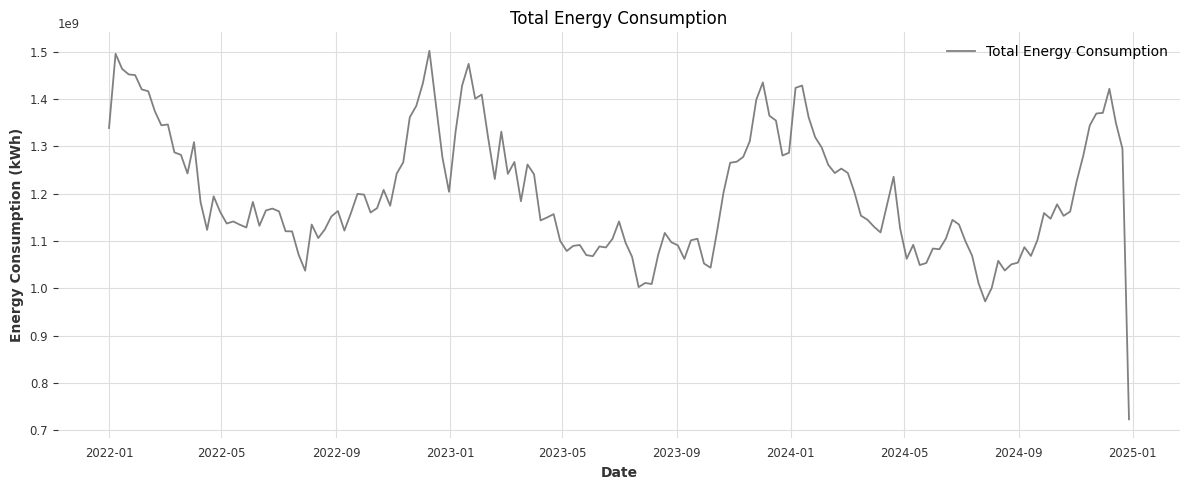

In [182]:
if not globals().get("NO_VISUALS", False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='gray')
    ax.set_title('Total Energy Consumption')
    ax.set_xlabel('Date')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

**III. 1. Stationarity of my Time Series**

Formal checks will be added in next chapters

To-do: forecast par semaine, dépend de swissgrid, 

Ecrire chaque concept dans le rapport

graph de xt+i - xt

**III. 1.a. Informal check**

# III. 1.a. i. Mean Calculation

Calculating the mean of my time series (Total Power Consumption in the Grid)

the formula for the mean is: μ = (x₁ + x₂ + ... + xₙ) / n

In [183]:
def mean(data):
    return sum(data) / len(data)

In [184]:
print(mean(energy_consumption_data))

1199913828.1385043


In [185]:
def sliced_mean_calculator(data, time_index,variance_window_size):
    means = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = mean(window_slice)
        means.append(var)
        time_indices.append(time_index[i + variance_window_size - 1])
    return means, time_indices

In [186]:
mean_window_size = len(energy_consumption_data) // 10

In [187]:
means, time_indices = sliced_mean_calculator(energy_consumption_data,time_index, mean_window_size)

Plotting Mean over time

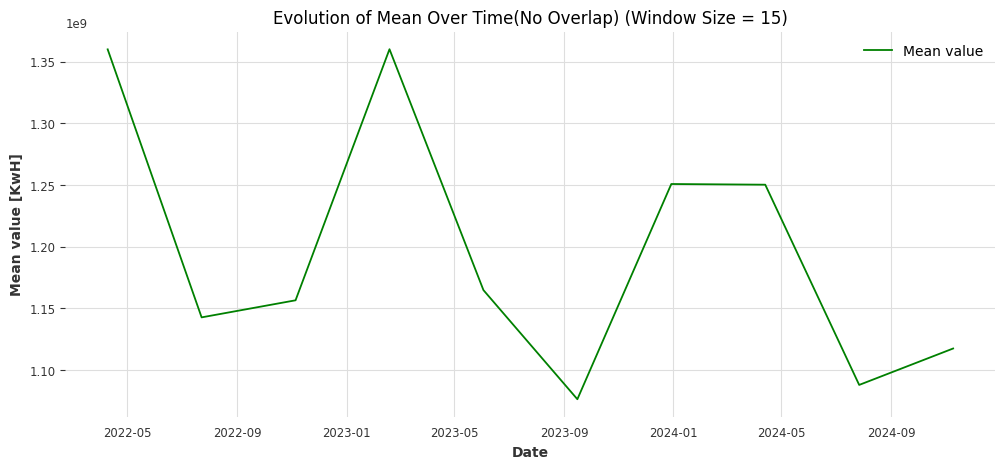

In [188]:
if not globals().get("NO_VISUALS", False):
    plt.figure(figsize=(12, 5))
    plt.plot(time_indices, means, color='green', label='Mean value')
    plt.xlabel('Date')
    plt.ylabel('Mean value [KwH]')
    plt.title(f'Evolution of Mean Over Time(No Overlap) (Window Size = {mean_window_size})')
    plt.grid(True)
    plt.legend()
    plt.show()

In [213]:
energy_consumption_data[0] = means[0]
energy_consumption_data[-1] = means [-1]

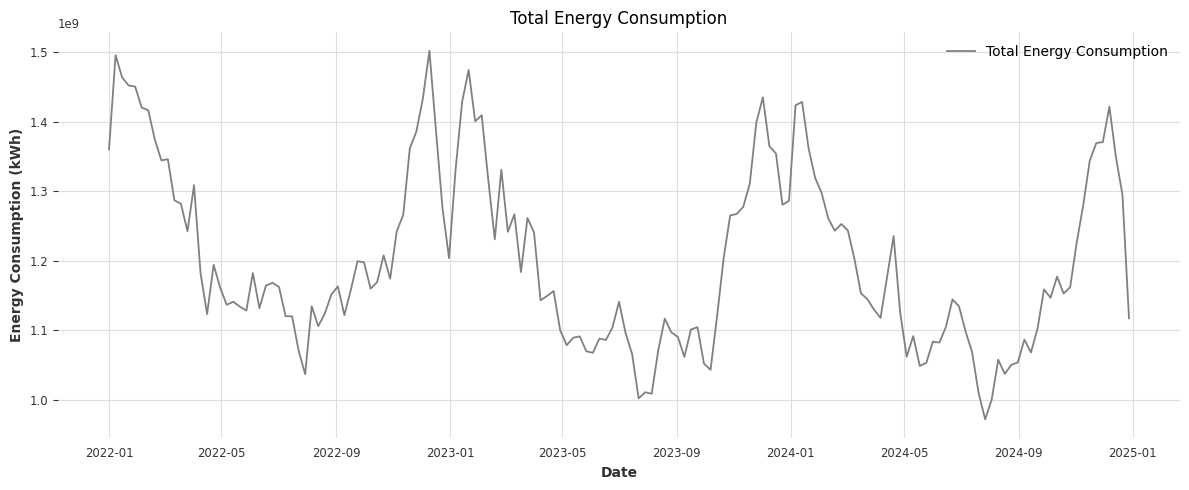

In [218]:
if not globals().get("NO_VISUALS", False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time_index, energy_consumption_data, label='Total Energy Consumption', color='gray')
    ax.set_title('Total Energy Consumption')
    ax.set_xlabel('Date')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# III. 1.a. ii. Variance Calculation

Calculating Variance:

Variance = 1/n sum(xi- mean)**2

In [191]:
def variance(data):
    mean_value = mean(data)
    variance = sum((x - mean_value)**2 for x in data) / len(data)
    return variance

In [192]:
print(variance(energy_consumption_data))

1.735630692361429e+16


Plotting variance over time

In [193]:
total_length =  len(energy_consumption_data)
variance_window_size = total_length // 10

In [194]:
print(variance_window_size)

15


Defining variance, time arrays

In [195]:
def sliced_variances_calculator(data, time_index,variance_window_size):
    variances = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = variance(window_slice)
        variances.append(var)
        time_indices.append(time_index[i + variance_window_size - 1]) 
    return variances, time_indices


In [196]:
variances, time_indices = sliced_variances_calculator(energy_consumption_data,time_index, variance_window_size)

In [197]:
print(variances, time_indices)

[7530043982607567.0, 869134329872836.5, 2237846043815563.0, 7214528226143497.0, 6735329514494805.0, 1540431538146303.8, 1.3936833874959886e+16, 9413444828588520.0, 3478862917688383.5, 5546789777234061.0] [Timestamp('2022-04-09 00:00:00'), Timestamp('2022-07-23 00:00:00'), Timestamp('2022-11-05 00:00:00'), Timestamp('2023-02-18 00:00:00'), Timestamp('2023-06-03 00:00:00'), Timestamp('2023-09-16 00:00:00'), Timestamp('2023-12-30 00:00:00'), Timestamp('2024-04-13 00:00:00'), Timestamp('2024-07-27 00:00:00'), Timestamp('2024-11-09 00:00:00')]


Plotting Variance over time

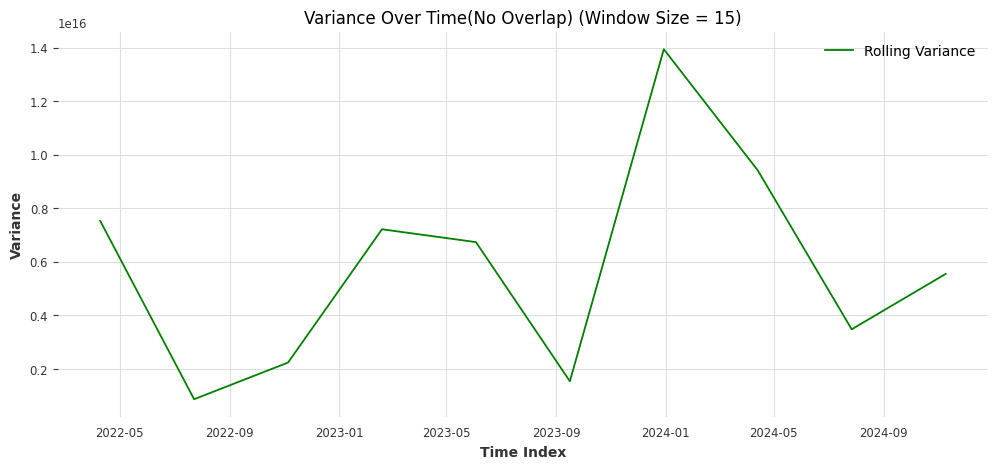

In [198]:
if not globals().get("NO_VISUALS", False):
    plt.figure(figsize=(12, 5))
    plt.plot(time_indices, variances, color='green', label='Rolling Variance')
    plt.xlabel('Time Index')
    plt.ylabel('Variance')
    plt.title(f'Variance Over Time(No Overlap) (Window Size = {variance_window_size})')
    plt.grid(True)
    plt.legend()
    plt.show()

**III. 1.a. iii. Autocorrelation Calculation**

In [199]:
from statsmodels.tsa.stattools import acf

autocorrelation function (ACF) at lag k, for k ≥ 0, of the time series is defined by
ro k = ck/ c0 where ck is the autocovariance at lag k

In [200]:
alpha = 0.05
confint = 1 - alpha
nlags = 60

In [201]:
import numpy as np

In [202]:
def check_autocorrelation(data, nlags=10, alpha=0.05):
    data = np.asarray(data)
    acf_vals, _ = acf(data, nlags=nlags, alpha=alpha) 
    return acf_vals


In [203]:
acf_vals = check_autocorrelation(energy_consumption_data, nlags=nlags)

In [204]:
if not globals().get("NO_VISUALS", False):
    print(f"High Autocorrelation defined as {1 - alpha}")
    for lag in range(1, nlags + 1):
        print(f"lag {lag:2d} → ACF = {acf_vals[lag]: .4f}")

High Autocorrelation defined as 0.95
lag  1 → ACF =  0.8207
lag  2 → ACF =  0.7131
lag  3 → ACF =  0.6157
lag  4 → ACF =  0.5517
lag  5 → ACF =  0.4914
lag  6 → ACF =  0.4406
lag  7 → ACF =  0.3962
lag  8 → ACF =  0.3262
lag  9 → ACF =  0.2641
lag 10 → ACF =  0.1917
lag 11 → ACF =  0.1142
lag 12 → ACF =  0.0289
lag 13 → ACF = -0.0569
lag 14 → ACF = -0.1199
lag 15 → ACF = -0.1632
lag 16 → ACF = -0.2277
lag 17 → ACF = -0.2793
lag 18 → ACF = -0.3073
lag 19 → ACF = -0.3395
lag 20 → ACF = -0.3531
lag 21 → ACF = -0.3544
lag 22 → ACF = -0.3598
lag 23 → ACF = -0.3929
lag 24 → ACF = -0.4365
lag 25 → ACF = -0.4719
lag 26 → ACF = -0.5045
lag 27 → ACF = -0.5105
lag 28 → ACF = -0.4870
lag 29 → ACF = -0.4361
lag 30 → ACF = -0.3936
lag 31 → ACF = -0.3589
lag 32 → ACF = -0.3392
lag 33 → ACF = -0.3092
lag 34 → ACF = -0.2704
lag 35 → ACF = -0.2388
lag 36 → ACF = -0.2016
lag 37 → ACF = -0.1323
lag 38 → ACF = -0.0554
lag 39 → ACF =  0.0080
lag 40 → ACF =  0.0965
lag 41 → ACF =  0.1721
lag 42 → ACF =  0.22

Setting axis at 0

There’s no point in computing the correlogram for a visibly non-stationary series—consider only
the stationary portion of the temperature data in the next plot. (Boris). I will then difference my TS then apply ACF.

In [205]:
from darts import TimeSeries

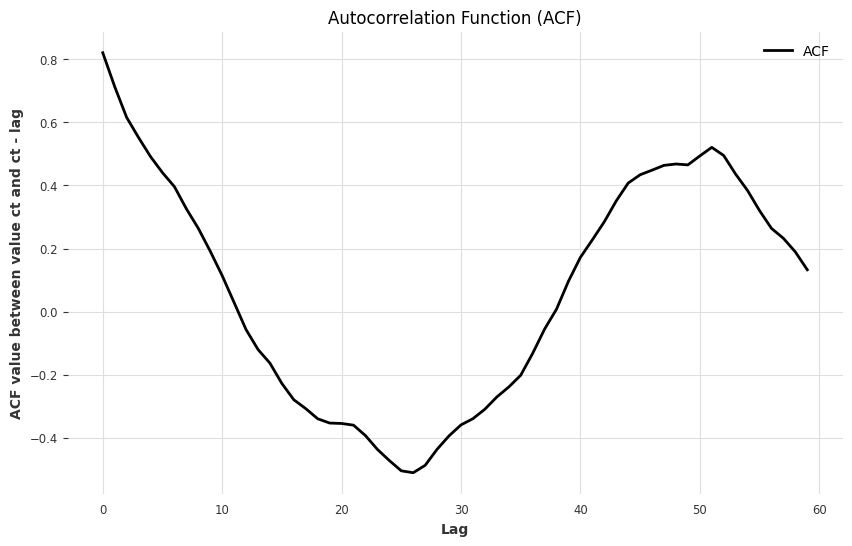

In [206]:
acf_series = TimeSeries.from_values(acf_vals[1:])
if not globals().get("NO_VISUALS", False):
    plt.figure(figsize=(10, 6))
    acf_series.plot(label="ACF")
    plt.title("Autocorrelation Function (ACF)")
    plt.xlabel("Lag")
    plt.ylabel("ACF value between value ct and ct - lag")
    plt.legend(loc="upper right")
    plt.show()

PACF: I calculated PACF starting from the ACF Function

After calculating the autocovariance vector, I'm going to use Yule-Walker Modified Method to calculate the PACF vector

This is given by the formula R . ϕ = r where R is the Yule-Walker matrix , r is the ACF vector, ϕ is the PACF vector we're looking for

In [207]:
from scipy.linalg import toeplitz

In [208]:
def pacf_yule_walker_full(gamma: np.ndarray, nlags: int):
    pacf_vals = []
    for k in range(1, nlags + 1):
        R = toeplitz(gamma[:k])          
        r = gamma[1:k+1]                 # r_k: γ(1) to γ(k)
        phi = solve(R, r)                # Solving for R * phi = r
        pacf_vals.append(phi[-1])      
    return np.array(pacf_vals)
from numpy.linalg import solve

In [209]:
pacf_phi_vector = pacf_yule_walker_full(acf_vals, nlags=nlags)

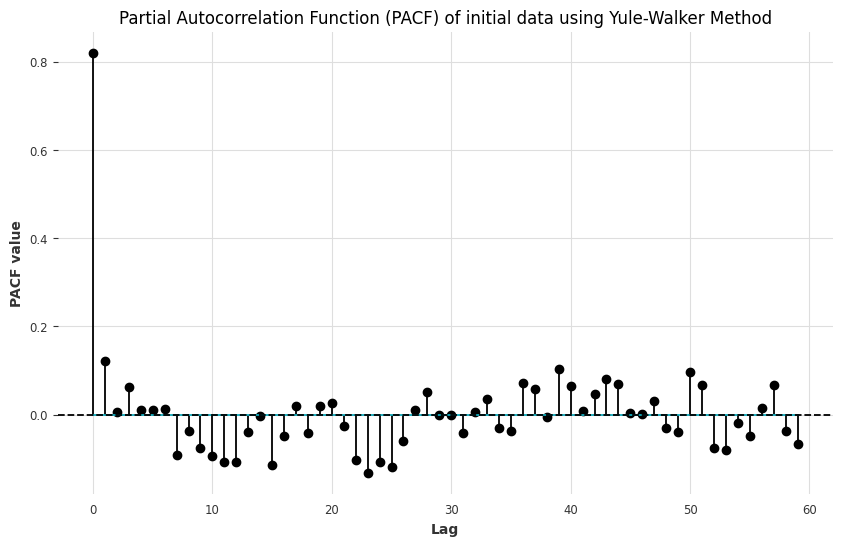

In [210]:
lags = np.arange(len(pacf_phi_vector))  
pacf_vals = pacf_phi_vector
if not globals().get("NO_VISUALS", False):
    plt.figure(figsize=(10, 6))
    plt.stem(lags, pacf_vals)
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Partial Autocorrelation Function (PACF) of initial data using Yule-Walker Method")
    plt.xlabel("Lag")
    plt.ylabel("PACF value")
    plt.grid(True)
    plt.show()


In [211]:
from darts.utils.statistics import (
    remove_trend,
    plot_acf,
    plot_pacf,
)

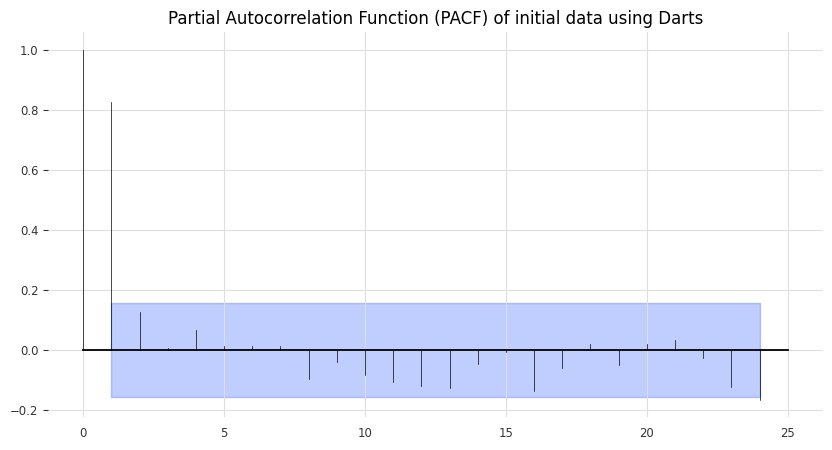

In [212]:
if not globals().get("NO_VISUALS", False):
    plot_pacf(TimeSeries.from_values(energy_consumption_data))
    plt.title("Partial Autocorrelation Function (PACF) of initial data using Darts")  